### Demonstration with pre-trained models


In [13]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from model import LSTM, Convolutional, FeedForward
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, TensorDataset
from utils import plot_pred_target, step_by_step

In [14]:
model_type = "fnn"

df = pd.read_csv(f"data/{model_type}.csv")

df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)

df.head()

,temperature,consumption,next_consumption,time_of_day,day_of_week,day_of_year
timestamp,,,,,,
2017-05-01 01:00:00+00:00,1.8,3325.431995,3344.690998,1,0,121
2017-05-01 02:00:00+00:00,3.2,3344.690998,3398.359002,2,0,121
2017-05-01 03:00:00+00:00,3.6,3398.359002,3430.220001,3,0,121
2017-05-01 04:00:00+00:00,3.4,3430.220001,3606.750000,4,0,121
2017-05-01 05:00:00+00:00,3.1,3606.750000,3739.876998,5,0,121


### Split data


In [15]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)
df_train, df_val = train_test_split(df_train, test_size=0.1, shuffle=False)

### Normalize


In [16]:
train_mean = df_train.mean()
train_std = df_train.std()

df_test = (df_test - train_mean) / train_std

df_test.head()

,temperature,consumption,next_consumption,time_of_day,day_of_week,day_of_year
timestamp,,,,,,
2022-08-31 19:00:00+00:00,0.673462,-0.960464,-0.966878,1.083558,-0.498387,0.52916
2022-08-31 20:00:00+00:00,0.528477,-0.966849,-1.067059,1.228027,-0.498387,0.52916
2022-08-31 21:00:00+00:00,0.443903,-1.067032,-1.196899,1.372497,-0.498387,0.52916
2022-08-31 22:00:00+00:00,0.395575,-1.196872,-1.307789,1.516967,-0.498387,0.52916
2022-08-31 23:00:00+00:00,0.407657,-1.307762,-1.387121,1.661436,-0.498387,0.52916


### Load pre-trained model


In [17]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

model = (
    FeedForward()
    if model_type == "fnn"
    else Convolutional(tw=100)
    if model_type == "lstm"
    else LSTM(device=device)
    if model_type == "cnn"
    else None
)

model.to(device)

model.load_state_dict(torch.load(f"models/{model_type}.pth"))

<All keys matched successfully>

### Testing and plotting comparison


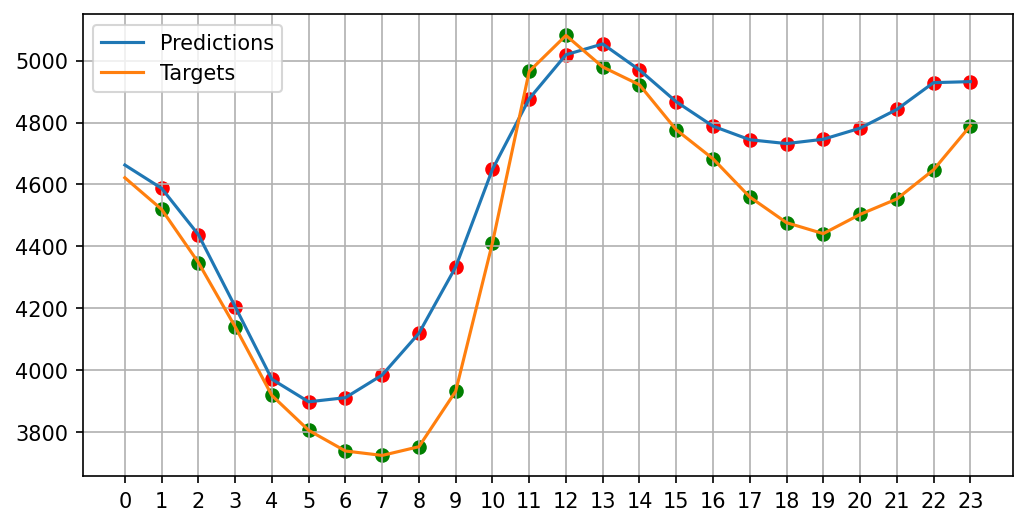

In [18]:
if model_type == "fnn":
    features_test = torch.tensor(
        df_test.drop(columns=["next_consumption"]).values.astype(np.float32)
    )
    test = torch.tensor(df_test["next_consumption"].values.astype(np.float32))

    test_tensor = TensorDataset(features_test, test)
    test_loader = DataLoader(test_tensor, batch_size=24, shuffle=False)

    predictions = step_by_step(
        model, device, test_loader=test_loader, std=train_std, mean=train_mean
    )

    plot_pred_target(predictions=predictions, idx=200)